In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

Split data into 80:20 for train and test data

In [ ]:
df=pd.read_csv('NFLX.csv')
df.drop(['Date'],inplace=True,axis=1)
def create_train_test_set(df_Stock):
    features = df_Stock.drop(columns=['Open','Volume','Adj Close'], axis=1)
    target = df_Stock['Open']
    data_len = df_Stock.shape[0]
    train_split = int(data_len * 0.80)
    X_train, X_test = features[:train_split], features[train_split:]
    Y_train,  Y_test = target[:train_split], target[train_split:]
    return X_train, X_test, Y_train, Y_test
X_train,X_test, y_train, y_test = create_train_test_set(df)

MLR Model

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [ 0.91443251  0.73647674 -0.65211962]
LR Intercept: 
 -0.029044072542376398


In [ ]:
print("Performance (R^2): ", lr.score(X_train, y_train))

Performance (R^2):  0.9998806051430045


In [ ]:
Y_pred = lr.predict(X_test)

In [ ]:
for i in range(len(Y_pred)):
  Y_pred[i]=int(Y_pred[i])

In [ ]:
print("Test RMSE: ",(np.sqrt(np.mean((y_test-Y_pred)**2))))

Test RMSE:  3.976642104838476


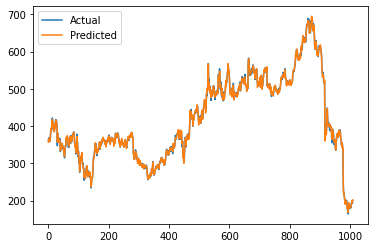

In [ ]:
plt.plot(y_test.tolist(),label='Actual')
plt.plot(Y_pred,label='Predicted')
plt.legend()

ARIMA and SARIMAX

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('NFLX.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


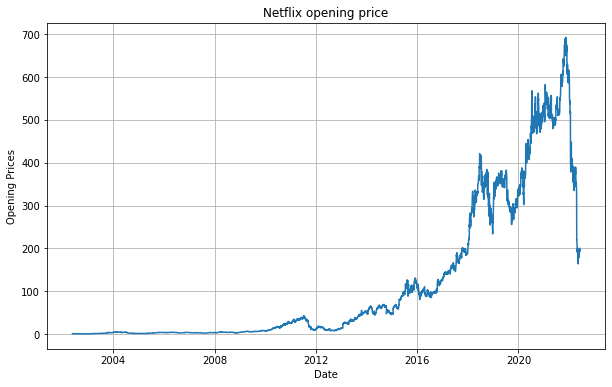

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Opening Prices')
plt.plot(stock_data['Open'])
plt.title('Netflix opening price')
plt.show()

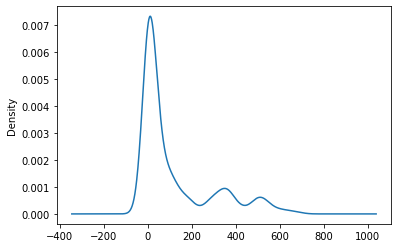

In [ ]:
#probability distribution
df_open = stock_data['Open']
df_open.plot(kind='kde')

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

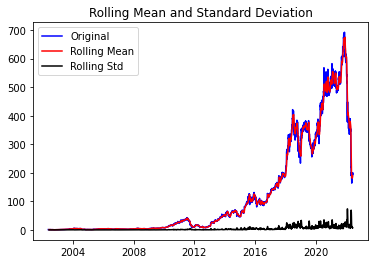

Results of dickey fuller test
Test Statistics                  -1.333673
p-value                           0.613630
No. of lags used                 32.000000
Number of observations used    5011.000000
critical value (1%)              -3.431656
critical value (5%)              -2.862117
critical value (10%)             -2.567077
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_open)

We can notice that the variance and mean is not constant so it is a sign for non-stationarity

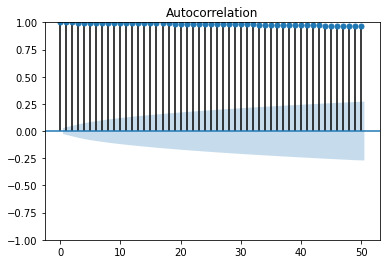

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(df_open, lags=50)
plt.show()

ACF is decreasing gradually so it is non-stationary

<Figure size 432x288 with 0 Axes>

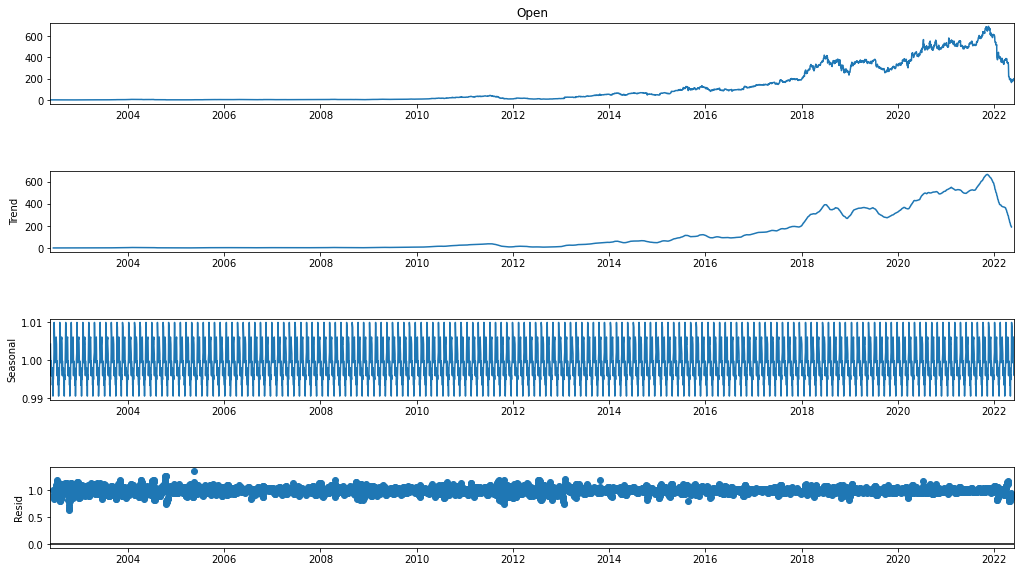

In [ ]:
result = seasonal_decompose(df_open, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Split data into train and test data with 80:20 split

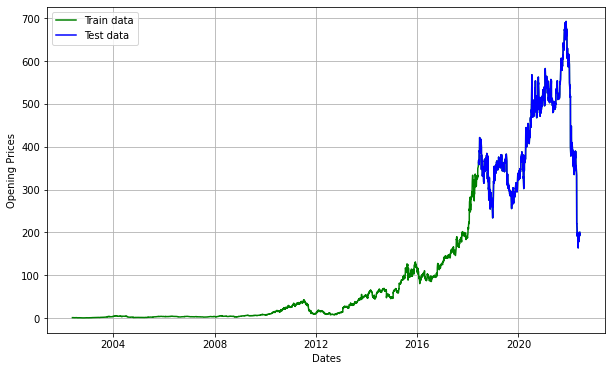

In [ ]:
train_data, test_data = df_open[:int(len(df_open)*0.8)], df_open[int(len(df_open)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(df_open, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Training model with SARIMAX using Volume as an exogeneous variable

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16778.497, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16777.834, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16777.869, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16784.724, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16779.781, Time=0.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16782.178, Time=3.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16773.876, Time=6.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16739.189, Time=3.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16737.250, Time=1.58 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16742.185, Time=0.81 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 18.229 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4035
Model:               SARIMAX(3, 1, 0)   Log Likelih

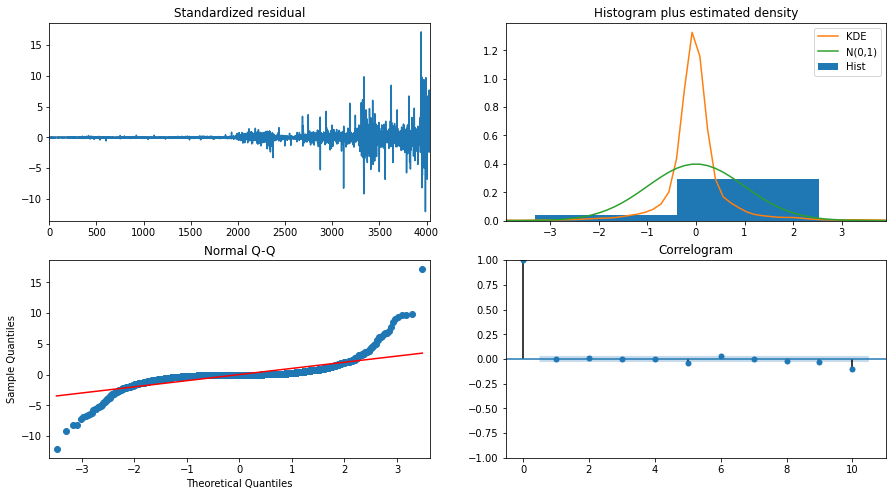

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,exogenous=df['Volume'][:int(len(df_open)*0.8)])
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data,exog=stock_data['Volume'][:int(len(df_open)*0.8)], order=(3, 1, 0))
fitted1 = model.fit()  
print(fitted1.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4035
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8367.082
Date:                Wed, 09 Nov 2022   AIC                          16744.164
Time:                        08:12:02   BIC                          16775.677
Sample:                             0   HQIC                         16755.330
                               - 4035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      1.632e-10   1.38e-09      0.118      0.906   -2.54e-09    2.86e-09
ar.L1         -0.0241      0.004     -5.695      0.000      -0.032      -0.016
ar.L2          0.0083      0.005      1.606      0.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4035
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8367.082
Date:                Wed, 09 Nov 2022   AIC                          16744.164
Time:                        08:12:34   BIC                          16775.677
Sample:                             0   HQIC                         16755.330
                               - 4035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      1.632e-10   1.38e-09      0.118      0.906   -2.54e-09    2.86e-09
ar.L1         -0.0241      0.004     -5.695      0.000      -0.032      -0.016
ar.L2          0.0083      0.005      1.606      0.1

In [ ]:
train_data=train_data.to_frame()
train_data['Open']=pd.to_numeric(train_data['Open'])
train_data['Predictions'] = list(fitted1.predict(0, len(train_data)-1))

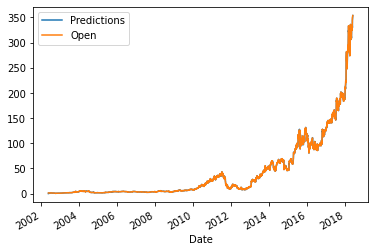

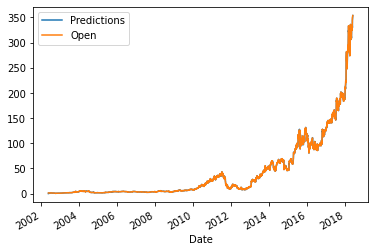

In [ ]:
#Plot predicted and actual Opening values
train_data.plot(y=['Predictions','Open'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


4035    353.998770
4036    354.134262
4037    354.139283
4038    354.151390
4039    354.167794
4040    354.167850
4041    354.168396
4042    354.170048
4043    354.169799
4044    354.170089
4045    354.170110
4046    354.169963
4047    354.170067
4048    354.170215
4049    354.170340
4050    354.170704
4051    354.170717
4052    354.171689
4053    354.170820
4054    354.170923
Name: predicted_mean, dtype: float64
RMSE: 128.93835965836521


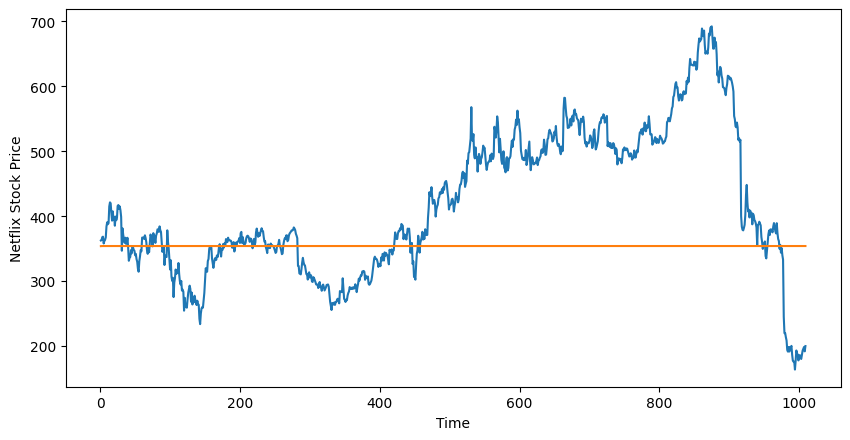

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


4035    353.998770
4036    354.134262
4037    354.139283
4038    354.151390
4039    354.167794
4040    354.167850
4041    354.168396
4042    354.170048
4043    354.169799
4044    354.170089
4045    354.170110
4046    354.169963
4047    354.170067
4048    354.170215
4049    354.170340
4050    354.170704
4051    354.170717
4052    354.171689
4053    354.170820
4054    354.170923
Name: predicted_mean, dtype: float64
RMSE: 128.93835965836521


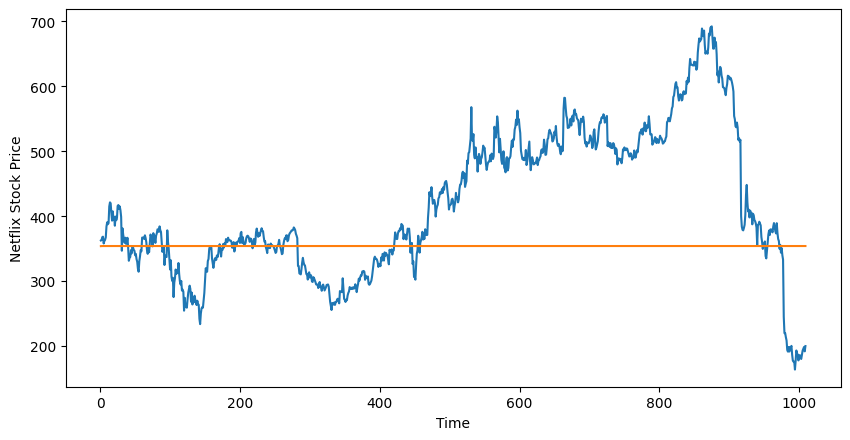

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
fc = fitted1.forecast(len(test_data), alpha=0.05,exog=stock_data['Volume'][:int(len(df_open)*0.2+1)])
fc_series = pd.Series(fc, index=test_data.index)
x=np.arange(1,len(fc)+1)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x,test_data)
plt.plot(x,fc)
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

RMSE is 128.9383

Training model with ARIMA model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16778.497, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16777.834, Time=0.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16777.869, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16784.724, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16779.781, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16782.178, Time=2.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16773.876, Time=5.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16739.189, Time=3.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16737.250, Time=0.91 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16742.185, Time=0.33 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 16.469 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4035
Model:               SARIMAX(3, 1, 0)   Log Likelih

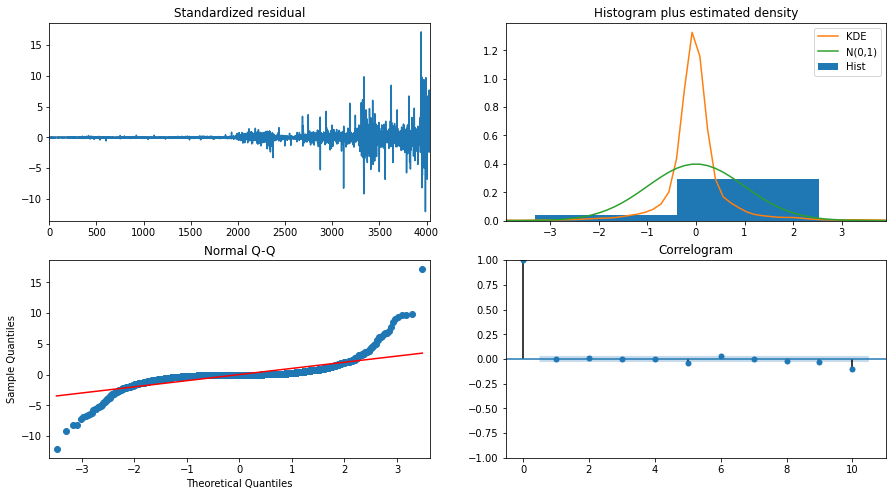

In [ ]:
model_autoARIMA = auto_arima(train_data['Open'], start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=True,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data['Open'], order=(3, 1, 0))
fitted2 = model.fit()  
print(fitted2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4035
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -8367.093
Date:                Wed, 09 Nov 2022   AIC                          16742.185
Time:                        08:12:21   BIC                          16767.395
Sample:                             0   HQIC                         16751.118
                               - 4035                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0241      0.004     -5.697      0.000      -0.032      -0.016
ar.L2          0.0083      0.005      1.613      0.107      -0.002       0.018
ar.L3          0.1067      0.007     16.119      0.0

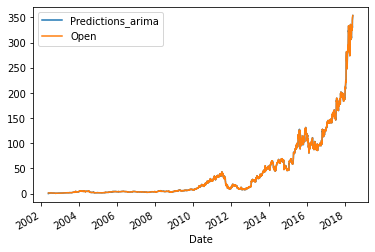

In [ ]:
train_data['Predictions_arima'] = list(fitted2.predict(0, len(train_data)-1))
train_data.plot(y=['Predictions_arima','Open'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


4035    353.982715
4036    354.133453
4037    354.139209
4038    354.151274
4039    354.167112
4040    354.167444
4041    354.168855
4042    354.170513
4043    354.170520
4044    354.170684
4045    354.170857
4046    354.170855
4047    354.170874
4048    354.170892
4049    354.170891
4050    354.170894
4051    354.170895
4052    354.170895
4053    354.170896
4054    354.170896
Name: predicted_mean, dtype: float64
RMSE: 128.9390268418769


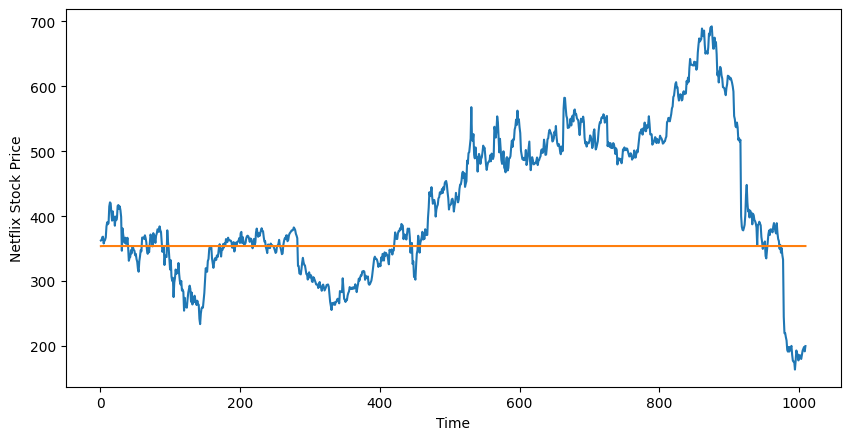

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
fc = fitted2.forecast(len(test_data), alpha=0.05)
x=np.arange(1,len(fc)+1)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x,test_data)
plt.plot(x,fc)
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

RMSE value is 128.9390